## Proof of Concept
- convert text to frequency that represents changes in format
- split text based on "major" changes in frequency

In [1]:
%config IPCompleter.greedy=True

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
import re
import numpy as np

from faker import Faker

In [4]:
%%html

<h5>1. setup</h5>

In [5]:
fake = Faker()

In [6]:
document = '\n'

for _ in range(10):
    l = np.random.randint(5, 15)
    document += '  ' + fake.word() + ':  ' + fake.sentence(l) + '\n'

document += '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \
     + '     abc: 10     abc: 10     abc: 10    ' + '\n' \

print('example document:')
print('-----------------------------------------')
print(document)
print('-----------------------------------------')

example document:
-----------------------------------------

  everything:  Future management themselves clearly.
  know:  Word and by join word mouth body along send.
  budget:  Focus tough past newspaper although health just common improve company.
  allow:  Certainly certainly physical everyone tough these chance.
  north:  Grow leave would financial behind here suggest suffer investment.
  what:  Half rise different time factor let police.
  successful:  Reality wind tree against benefit win.
  teach:  Focus page word public party sister executive then since experience ok result determine floor test.
  vote:  These mother very suddenly property speak look situation general.
  doctor:  Edge human go father power.

     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    

     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10  

In [7]:
%%html

<h5>2. convert document to matrix</h5>

In [8]:
lines_in_document = list(filter(lambda x: x != '', document.split('\n')))

In [9]:
## shape
length = len(lines_in_document)
width = np.max(
    [
        len(line)
        for line
        in lines_in_document
    ]
)

document_as_matrix = np.zeros((length, width))

In [10]:
## transform,

for r, line in enumerate(lines_in_document):
    generator = enumerate(line.replace('\s', ' '))

    for c, char in enumerate(line.replace('\s', ' ')):
        if char == ' ':
            pass
        elif re.match(r'[\d.]', char):
            document_as_matrix[r, c] = .95
        elif re.match(r'[=:-~]', char):
            document_as_matrix[r, c] = .90
        else:
            document_as_matrix[r, c] = 1

In [11]:
## apply filters,
for row in range(length):
    row_values = document_as_matrix[row, :]
    for col in range(1, width-1):
        pv = row_values[col-1]
        cv = row_values[col]
        nv = row_values[col+1]
        
        if pv > 0 and nv > 0 and cv == 0:
            document_as_matrix[row, col] = .95

In [12]:
%%html

<h5>3. image / document</h5>

In [13]:
import matplotlib.pyplot as plt

In [14]:
%%html

<h5>view as image</h5>

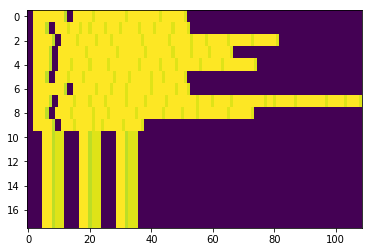

In [15]:
plt.imshow(document_as_matrix, aspect='auto')

In [16]:
%%html

<h5>view as time series</h5>

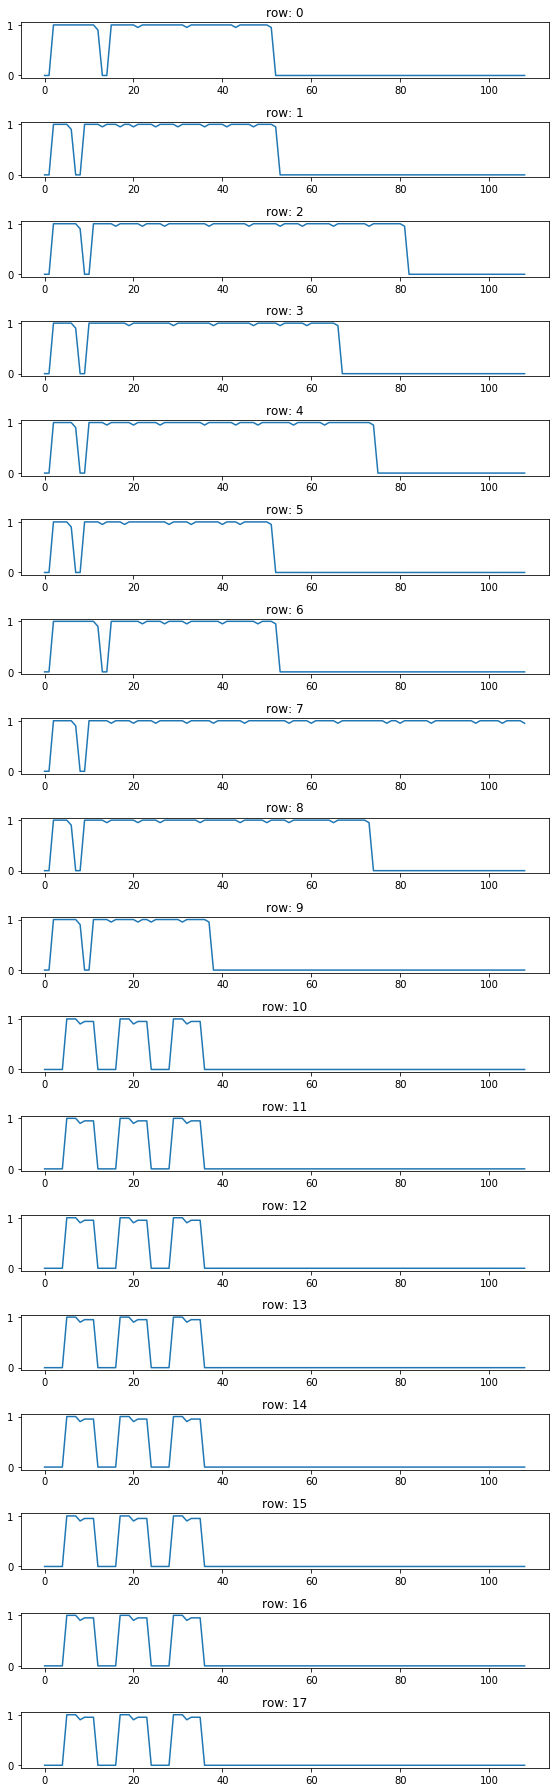

In [17]:
fig, axs = plt.subplots(length, 1, figsize=(8, 25))

for row in range(length):
    axs[row].plot(document_as_matrix[row, :])
    axs[row].set_title('row: ' + str(row))
    
fig.tight_layout()
fig.show()

In [18]:
%%html

<h5>split document</h5>

In [19]:
import math

def strip_array(array):
    for col in np.flip(range(len(array))):
        if array[col] != 0.0:
            break
    
    return array[:col]

In [20]:
y = []
for row in range(1, length):
    a_orig = document_as_matrix[row-1, :]
    b_orig = document_as_matrix[row, :]
    
    a = strip_array(a_orig)
    b = strip_array(b_orig)

    a_len = len(a)
    b_len = len(b)
    
    value = 0
    if a_len != 0 and b_len != 0:
        if a_len > b_len:
            a = a[:b_len]
        if b_len > a_len:
            b = b[:a_len]

        m = np.array([a, b])
        value = np.corrcoef(m)[0, 1]
        if math.isnan(value):
            value = 0

    y.append(abs(value))

In [21]:
threshold = .35
split_points = [ 
    index + 1
    for index, value
    in enumerate(y)
    if value < threshold 
]

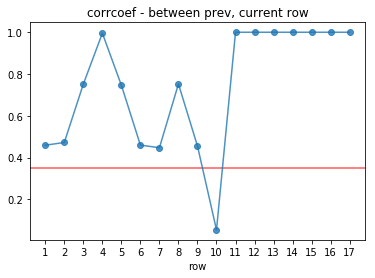

In [22]:
x_ticks = range(length)
plt.xticks(x_ticks)

plt.axhline(.35, c = 'red', alpha = .65)

x = range(1, length)

plt.title('corrcoef - between prev, current row')
plt.xlabel('row')

plt.plot(x, y, '-o', alpha = .8)
plt.show()

In [23]:
sections = []

prev_split_point = 0
for current_split_point in split_points:
    section = lines_in_document[prev_split_point:current_split_point]
    sections.append('\n'.join(section))
        
    prev_split_point = current_split_point
    
section = lines_in_document[prev_split_point:]
sections.append('\n'.join(section))

In [24]:
for index, section in enumerate(sections):
    print('section:', index+1)
    print('-->')
    print(section)
    print('<--')
    print()

section: 1
-->
  everything:  Future management themselves clearly.
  know:  Word and by join word mouth body along send.
  budget:  Focus tough past newspaper although health just common improve company.
  allow:  Certainly certainly physical everyone tough these chance.
  north:  Grow leave would financial behind here suggest suffer investment.
  what:  Half rise different time factor let police.
  successful:  Reality wind tree against benefit win.
  teach:  Focus page word public party sister executive then since experience ok result determine floor test.
  vote:  These mother very suddenly property speak look situation general.
  doctor:  Edge human go father power.
<--

section: 2
-->
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10     abc: 10     abc: 10    
     abc: 10 